# Rainfall Prediction over Michigan Lake using CNN and RNN
-----------------------------
#### Teammates:
* Krishnakanth Naik Jarapala
* Uday 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import pandas as pd
import numpy as np
import pickle
import ast


# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, ConvLSTM2D, Dropout, Flatten, RepeatVector, Reshape, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping

2024-04-23 21:18:00.261424: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 21:18:06.003681: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


* Load the Dataset

In [2]:
df = pd.read_csv('./recent_18_months_les_data_preprocessed_422.csv')
df = df.drop('Lake_data_1D', axis=1)
df.head()

,Date_UTC,Time_UTC,datetime,year_month,day_sin,day_cos,year_sin,year_cos,Wind_x,Wind_y,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Precip_in
0,2014-10-01,00:00,2014-10-01 00:00:00,2014-10,-1.331485e-12,1.000000,-0.999946,-0.010354,9.526279,-5.500000e+00,48.0,93.0,800,4,992.7,0.05
1,2014-10-01,01:00,2014-10-01 01:00:00,2014-10,2.588190e-01,0.965926,-0.999954,-0.009637,8.457234,-3.078181e+00,48.0,93.0,800,4,993.3,0.05
2,2014-10-01,02:00,2014-10-01 02:00:00,2014-10,5.000000e-01,0.866025,-0.999960,-0.008920,8.000000,-1.959435e-15,49.0,89.0,600,6,993.0,0.04
3,2014-10-01,03:00,2014-10-01 03:00:00,2014-10,7.071068e-01,0.707107,-0.999966,-0.008203,8.660254,5.000000e+00,48.0,87.0,1200,8,993.0,0.01
4,2014-10-01,04:00,2014-10-01 04:00:00,2014-10,8.660254e-01,0.500000,-0.999972,-0.007487,5.142301,6.128356e+00,48.0,86.0,1000,10,993.7,0.00


* Data is not continuous, so lets create the sequence dataset by each window: [2014-10 - 2015-03] + [2015-10 - 2016-03] + [2016-10 - 2017-03]

In [3]:
mnts= df.year_month.unique().tolist()
yr_mnt_lst = []
for i in range(0, len(mnts), 6):
    # print(mnts[i: i+6])
    yr_mnt_lst.append(mnts[i: i+6])

yr_mnt_lst

[['2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03'],
 ['2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03'],
 ['2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03']]

In [4]:
df['sequence_window'] = -1

for i, val in enumerate(yr_mnt_lst):
    df.loc[df.year_month.isin(val), 'sequence_window'] = i+1


df.sequence_window.value_counts()

sequence_window
2    4392
1    4368
3    4368
Name: count, dtype: int64

### Creating a new feature - day_session 

* 0-8 ==> day-session- 1
* 8-16 ==> day-session- 2
* 16-24 ==> day-session- 3


*Idea: Train a model on 3 records per day - where we select the max precip record from one of the 8-hour duration (day-session)*

In [5]:
df['day_session'] = df['Time_UTC'].apply(lambda x: (int(x[:2])//8))
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.strftime('%Y-%m-%d')

In [6]:
# Rank order the records of each 8-hour session by Precip values in Descending order
df['RN'] = df.sort_values(['date','day_session', 'Precip_in'], ascending=[True,True, False]).groupby(['date','day_session']).cumcount()+1

Computing the sum-of-precip each day

In [7]:
df['sum_precip_in'] = 0

for i in df.date.unique():
    df.loc[df.date == i, 'sum_precip_in'] = np.round(df[df.date == i].Precip_in.sum(), 6)

df.head()

/tmp/ipykernel_23903/578452082.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.date == i, 'sum_precip_in'] = np.round(df[df.date == i].Precip_in.sum(), 6)


,Date_UTC,Time_UTC,datetime,year_month,day_sin,day_cos,year_sin,year_cos,Wind_x,Wind_y,...,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Precip_in,sequence_window,day_session,date,RN,sum_precip_in
0,2014-10-01,00:00,2014-10-01 00:00:00,2014-10,-1.331485e-12,1.000000,-0.999946,-0.010354,9.526279,-5.500000e+00,...,93.0,800,4,992.7,0.05,1,0,2014-10-01,1,0.15
1,2014-10-01,01:00,2014-10-01 01:00:00,2014-10,2.588190e-01,0.965926,-0.999954,-0.009637,8.457234,-3.078181e+00,...,93.0,800,4,993.3,0.05,1,0,2014-10-01,2,0.15
2,2014-10-01,02:00,2014-10-01 02:00:00,2014-10,5.000000e-01,0.866025,-0.999960,-0.008920,8.000000,-1.959435e-15,...,89.0,600,6,993.0,0.04,1,0,2014-10-01,3,0.15
3,2014-10-01,03:00,2014-10-01 03:00:00,2014-10,7.071068e-01,0.707107,-0.999966,-0.008203,8.660254,5.000000e+00,...,87.0,1200,8,993.0,0.01,1,0,2014-10-01,4,0.15
4,2014-10-01,04:00,2014-10-01 04:00:00,2014-10,8.660254e-01,0.500000,-0.999972,-0.007487,5.142301,6.128356e+00,...,86.0,1000,10,993.7,0.00,1,0,2014-10-01,5,0.15


---------------------------------------------------
### 2. Loading the Cloud-Images
*Load the Preprocessed Cloud-Images and select respective precip_in values from above data*

In [8]:
feats_req = ['datetime', 'date', 'year_month', 'Time_UTC', 'sum_precip_in']

images_df = df[(df['Time_UTC'] >= '14:00') & (df['Time_UTC'] <= '21:00')][feats_req].reset_index(drop=True)
print(f"Shape of the dataset: {images_df.shape}")

images_df.head()

Shape of the dataset: (4376, 5)


,datetime,date,year_month,Time_UTC,sum_precip_in
0,2014-10-01 14:00:00,2014-10-01,2014-10,14:00,0.15
1,2014-10-01 15:00:00,2014-10-01,2014-10,15:00,0.15
2,2014-10-01 16:00:00,2014-10-01,2014-10,16:00,0.15
3,2014-10-01 17:00:00,2014-10-01,2014-10,17:00,0.15
4,2014-10-01 18:00:00,2014-10-01,2014-10,18:00,0.15


In [9]:
from tqdm import tqdm
import cv2

images_array = []

# Load the 128, 128 images
g = '../data/lake_michigan_images_resized'

img_names = -1
for idx in tqdm(range(len(os.listdir(g)))):
    g_img = g + "/" + str(idx) + ".png"
    im = cv2.imread(g_img)
    # Storing 1 channel, since the images are grayscale, and cropping
    images_array.append(im[8:-8,8:-8,0]) # Crop the 8 pixel border

100%|██████████| 4376/4376 [00:16<00:00, 272.05it/s]


Plot couple of sequence images from 0th Index

Displaying next frames starting at image 0.


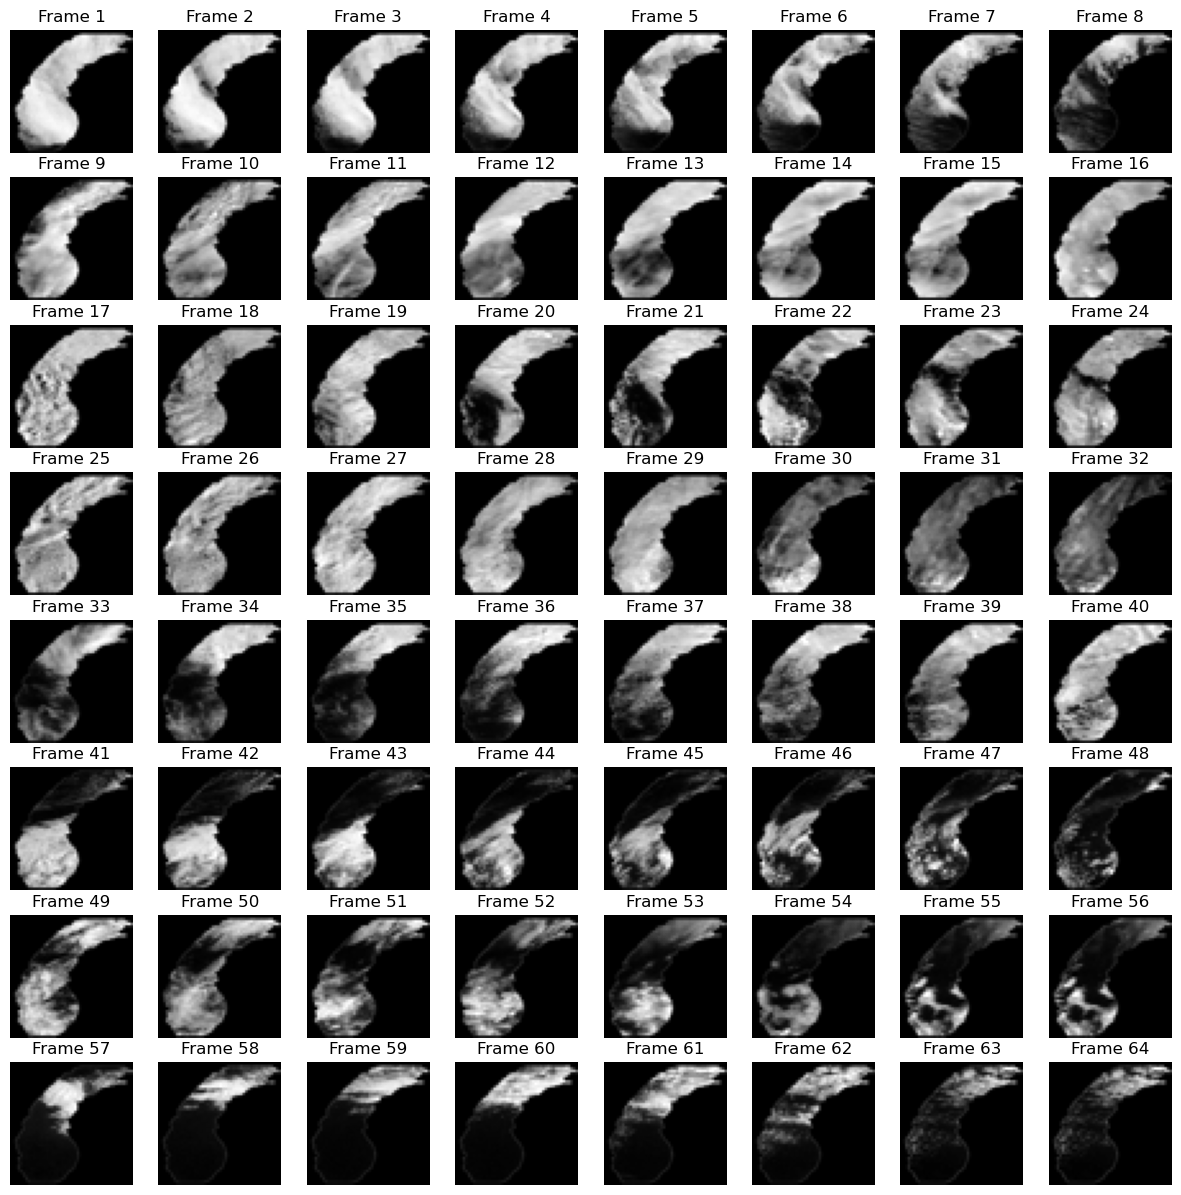

In [10]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

# Plot each of the sequential images for one random data example.
# data_choice = np.random.choice(range(len(images)), size=1)[0]
data_choice = 0 # Start from 0th index
for idx, ax in enumerate(axes.flat):
    ax.imshow(images_array[data_choice + idx], cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying next frames starting at image {data_choice}.")
plt.show()

In [11]:
images_df['image_array'] = images_array
images_df.head()

,datetime,date,year_month,Time_UTC,sum_precip_in,image_array
0,2014-10-01 14:00:00,2014-10-01,2014-10,14:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,2014-10-01 15:00:00,2014-10-01,2014-10,15:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2014-10-01 16:00:00,2014-10-01,2014-10,16:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,2014-10-01 17:00:00,2014-10-01,2014-10,17:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2014-10-01 18:00:00,2014-10-01,2014-10,18:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


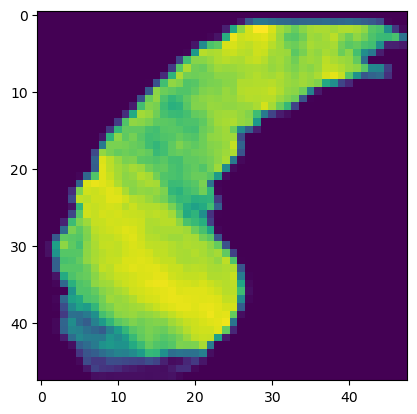

In [12]:
plt.imshow(images_df.image_array[0])

---------------------------------------------------
### 3. Creating the Day Level-data

In [13]:
pd.set_option('display.max_columns', None)
df.head()

,Date_UTC,Time_UTC,datetime,year_month,day_sin,day_cos,year_sin,year_cos,Wind_x,Wind_y,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Precip_in,sequence_window,day_session,date,RN,sum_precip_in
0,2014-10-01,00:00,2014-10-01 00:00:00,2014-10,-1.331485e-12,1.000000,-0.999946,-0.010354,9.526279,-5.500000e+00,48.0,93.0,800,4,992.7,0.05,1,0,2014-10-01,1,0.15
1,2014-10-01,01:00,2014-10-01 01:00:00,2014-10,2.588190e-01,0.965926,-0.999954,-0.009637,8.457234,-3.078181e+00,48.0,93.0,800,4,993.3,0.05,1,0,2014-10-01,2,0.15
2,2014-10-01,02:00,2014-10-01 02:00:00,2014-10,5.000000e-01,0.866025,-0.999960,-0.008920,8.000000,-1.959435e-15,49.0,89.0,600,6,993.0,0.04,1,0,2014-10-01,3,0.15
3,2014-10-01,03:00,2014-10-01 03:00:00,2014-10,7.071068e-01,0.707107,-0.999966,-0.008203,8.660254,5.000000e+00,48.0,87.0,1200,8,993.0,0.01,1,0,2014-10-01,4,0.15
4,2014-10-01,04:00,2014-10-01 04:00:00,2014-10,8.660254e-01,0.500000,-0.999972,-0.007487,5.142301,6.128356e+00,48.0,86.0,1000,10,993.7,0.00,1,0,2014-10-01,5,0.15


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13128 entries, 0 to 13127
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date_UTC         13128 non-null  object        
 1   Time_UTC         13128 non-null  object        
 2   datetime         13128 non-null  datetime64[ns]
 3   year_month       13128 non-null  object        
 4   day_sin          13128 non-null  float64       
 5   day_cos          13128 non-null  float64       
 6   year_sin         13128 non-null  float64       
 7   year_cos         13128 non-null  float64       
 8   Wind_x           13128 non-null  float64       
 9   Wind_y           13128 non-null  float64       
 10  Temp_F           13128 non-null  float64       
 11  RH_pct           13128 non-null  float64       
 12  Low_Cloud_Ht_ft  13128 non-null  int64         
 13  Visibility_mi    13128 non-null  int64         
 14  Atm_Press_hPa    13128 non-null  float

In [15]:
# Group by date and calculate mean for feature1, feature2, feature3 and max for feature4, feature5
day_level_data = df.groupby(df['datetime'].dt.date).agg({
    'year_month':'first',
    'day_sin': 'mean',
    'day_cos': 'mean',
    'year_sin': 'mean',
    'year_cos': 'mean',
    'Temp_F': 'mean',
    'RH_pct': 'mean',
    'Low_Cloud_Ht_ft': 'mean',
    'Atm_Press_hPa': 'mean',
    'Wind_x': 'mean',
    'Wind_y': 'mean',
    'Visibility_mi': 'mean',
    'Precip_in': 'sum'
}).reset_index()

day_level_data.columns = ['date', 'year_month','day_sin', 'day_cos', 'year_sin', 'year_cos', 'Temp_F','RH_pct', 'Low_Cloud_Ht_ft', 'Atm_Press_hPa', 'Wind_x', 'Wind_y','Visibility_mi', 'sum_precip_in']
day_level_data['date'] = pd.to_datetime(day_level_data['date'])
day_level_data['date'] = day_level_data['date'].dt.strftime('%Y-%m-%d')
day_level_data.head()

,date,year_month,day_sin,day_cos,year_sin,year_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Atm_Press_hPa,Wind_x,Wind_y,Visibility_mi,sum_precip_in
0,2014-10-01,2014-10,6.738822e-14,9.456325e-14,-0.999985,-0.002111,55.666667,79.375000,5183.333333,993.000000,0.423936,1.821162,9.250000,0.15
1,2014-10-02,2014-10,3.391708e-13,-3.548550e-13,-0.999874,0.015091,58.708333,85.583333,3075.000000,988.687500,-1.583594,2.211282,6.250000,0.94
2,2014-10-03,2014-10,-3.720542e-13,-1.794861e-15,-0.999466,0.032289,56.000000,79.041667,3195.833333,978.737500,-0.675702,-6.158806,8.416667,0.81
3,2014-10-04,2014-10,6.795490e-15,-5.167626e-14,-0.998763,0.049477,49.166667,81.666667,2795.833333,977.262500,-2.718467,-3.856504,8.875000,0.49
4,2014-10-05,2014-10,3.598510e-13,9.454012e-14,-0.997764,0.066650,45.000000,68.791667,4120.833333,978.191667,-3.623998,-4.426348,9.916667,0.01


In [16]:
day_level_data.sum_precip_in.value_counts(normalize=True)

sum_precip_in
0.00    0.537477
0.01    0.093236
0.02    0.051188
0.03    0.031079
0.04    0.027422
          ...   
0.30    0.001828
0.42    0.001828
0.54    0.001828
0.22    0.001828
0.26    0.001828
Name: proportion, Length: 61, dtype: float64

In [17]:
day_level_data[day_level_data.sum_precip_in > 0].sum_precip_in.describe()

count    253.000000
mean       0.130711
std        0.180845
min        0.010000
25%        0.020000
50%        0.060000
75%        0.160000
max        1.270000
Name: sum_precip_in, dtype: float64

### Classify the Precip into Rain-Classes:
        * 0 - No Rain
        * (0 - 0.06) - Med Rain
        * anything above 0.06 - High Rain

In [18]:
def classify_precip(val):
    high_rain_lower_limit = 0.06
    if val == 0:
        return "No_Rain"
    elif (val > 0) & (val <= high_rain_lower_limit):
        return "Medium_Rain"
    elif (val > high_rain_lower_limit):
        return "High_Rain"

In [19]:
day_level_data['rain_class'] = day_level_data['sum_precip_in'].apply(lambda x: classify_precip(x))
100*day_level_data.rain_class.value_counts(normalize=True)

rain_class
No_Rain        53.747715
High_Rain      23.217550
Medium_Rain    23.034735
Name: proportion, dtype: float64

In [20]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

# Assuming your class variable is named 'classes' and it is a list or array
classes = day_level_data['rain_class'].tolist()  # Your class variable

# Convert class variable to one-hot encoding
label_binarizer = LabelBinarizer()
one_hot_encoded = label_binarizer.fit_transform(classes)

# Convert the one-hot encoded array to a DataFrame
one_hot_df = pd.DataFrame(one_hot_encoded, columns=label_binarizer.classes_)

# Concatenate the one-hot encoded DataFrame with the original DataFrame 'tdf'
day_level_data_with_one_hot = pd.concat([day_level_data, one_hot_df], axis=1)


# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(classes), y=classes)

print("Class weights:")
print(class_weights)

day_level_data_with_one_hot.head()

Class weights:
[1.43569554 1.44708995 0.62018141]


,date,year_month,day_sin,day_cos,year_sin,year_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Atm_Press_hPa,Wind_x,Wind_y,Visibility_mi,sum_precip_in,rain_class,High_Rain,Medium_Rain,No_Rain
0,2014-10-01,2014-10,6.738822e-14,9.456325e-14,-0.999985,-0.002111,55.666667,79.375000,5183.333333,993.000000,0.423936,1.821162,9.250000,0.15,High_Rain,1,0,0
1,2014-10-02,2014-10,3.391708e-13,-3.548550e-13,-0.999874,0.015091,58.708333,85.583333,3075.000000,988.687500,-1.583594,2.211282,6.250000,0.94,High_Rain,1,0,0
2,2014-10-03,2014-10,-3.720542e-13,-1.794861e-15,-0.999466,0.032289,56.000000,79.041667,3195.833333,978.737500,-0.675702,-6.158806,8.416667,0.81,High_Rain,1,0,0
3,2014-10-04,2014-10,6.795490e-15,-5.167626e-14,-0.998763,0.049477,49.166667,81.666667,2795.833333,977.262500,-2.718467,-3.856504,8.875000,0.49,High_Rain,1,0,0
4,2014-10-05,2014-10,3.598510e-13,9.454012e-14,-0.997764,0.066650,45.000000,68.791667,4120.833333,978.191667,-3.623998,-4.426348,9.916667,0.01,Medium_Rain,0,1,0


### Classify the **precip** values in **Images_df** as well!

In [21]:
images_df.head()

,datetime,date,year_month,Time_UTC,sum_precip_in,image_array
0,2014-10-01 14:00:00,2014-10-01,2014-10,14:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,2014-10-01 15:00:00,2014-10-01,2014-10,15:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2014-10-01 16:00:00,2014-10-01,2014-10,16:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,2014-10-01 17:00:00,2014-10-01,2014-10,17:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2014-10-01 18:00:00,2014-10-01,2014-10,18:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [22]:
images_df['rain_class'] = images_df['sum_precip_in'].apply(lambda x: classify_precip(x))


# Assuming your class variable is named 'classes' and it is a list or array
classes1 = images_df['rain_class'].tolist()  # Your class variable

# Convert class variable to one-hot encoding
one_hot_encoded1 = label_binarizer.transform(classes1)

# Convert the one-hot encoded array to a DataFrame
one_hot_df1 = pd.DataFrame(one_hot_encoded1, columns=label_binarizer.classes_)

# Concatenate the one-hot encoded DataFrame with the original DataFrame 'tdf'
images_df_with_one_hot = pd.concat([images_df, one_hot_df1], axis=1)
images_df_with_one_hot.head()

,datetime,date,year_month,Time_UTC,sum_precip_in,image_array,rain_class,High_Rain,Medium_Rain,No_Rain
0,2014-10-01 14:00:00,2014-10-01,2014-10,14:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",High_Rain,1,0,0
1,2014-10-01 15:00:00,2014-10-01,2014-10,15:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",High_Rain,1,0,0
2,2014-10-01 16:00:00,2014-10-01,2014-10,16:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",High_Rain,1,0,0
3,2014-10-01 17:00:00,2014-10-01,2014-10,17:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",High_Rain,1,0,0
4,2014-10-01 18:00:00,2014-10-01,2014-10,18:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",High_Rain,1,0,0


#### Summary:
We have Day level, 8-hour session level and hourly data with the labels


    * df --- hourly and 8-hour session data
    * images_df, images_df_with_one_hot --- CNN images data
    * day_level_data, day_level_data_with_one_hot --- day level data with agg-precip values

In [23]:
day_level_data_with_one_hot.head()

,date,year_month,day_sin,day_cos,year_sin,year_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Atm_Press_hPa,Wind_x,Wind_y,Visibility_mi,sum_precip_in,rain_class,High_Rain,Medium_Rain,No_Rain
0,2014-10-01,2014-10,6.738822e-14,9.456325e-14,-0.999985,-0.002111,55.666667,79.375000,5183.333333,993.000000,0.423936,1.821162,9.250000,0.15,High_Rain,1,0,0
1,2014-10-02,2014-10,3.391708e-13,-3.548550e-13,-0.999874,0.015091,58.708333,85.583333,3075.000000,988.687500,-1.583594,2.211282,6.250000,0.94,High_Rain,1,0,0
2,2014-10-03,2014-10,-3.720542e-13,-1.794861e-15,-0.999466,0.032289,56.000000,79.041667,3195.833333,978.737500,-0.675702,-6.158806,8.416667,0.81,High_Rain,1,0,0
3,2014-10-04,2014-10,6.795490e-15,-5.167626e-14,-0.998763,0.049477,49.166667,81.666667,2795.833333,977.262500,-2.718467,-3.856504,8.875000,0.49,High_Rain,1,0,0
4,2014-10-05,2014-10,3.598510e-13,9.454012e-14,-0.997764,0.066650,45.000000,68.791667,4120.833333,978.191667,-3.623998,-4.426348,9.916667,0.01,Medium_Rain,0,1,0


In [26]:
# Calculate the counts for each class
counts = {
    'no_rain': images_df_with_one_hot['No_Rain'].mean(),
    'medium_rain': images_df_with_one_hot['Medium_Rain'].mean(),
    'high_rain': images_df_with_one_hot['High_Rain'].mean()
}

# Calculate the probabilities for each class
total_counts = sum(counts.values())
probabilities = {k: v / total_counts for k, v in counts.items()}

# Calculate the initial bias for each class
# In this case, we use 'no_rain' as the reference class probability
reference_probability = probabilities['no_rain']
initial_biases = np.log([
    probabilities['high_rain'] / reference_probability,
    probabilities['medium_rain'] / reference_probability,
    probabilities['no_rain'] / probabilities['no_rain']]
    )

print("Initial Biases:", initial_biases)

Initial Biases: [-0.84729786 -0.83939268  0.        ]


In [27]:
class_weights = {
    0: (1 / counts['high_rain']) * (total_counts / 3),
    1: (1 / counts['medium_rain']) * (total_counts / 3),
    2: (1 / counts['no_rain']) * (total_counts / 3)
}

print("Class Weights:", class_weights)

Class Weights: {0: 1.447089947089947, 1: 1.4356955380577427, 2: 0.6201814058956916}


-------------------------------------------------
# CNN

------------------------------------
### Create the Data Sequence for CNN model Training

In [103]:
def create_sequences_cnn(data,  feature_columns, label_columns, stride, past_time_steps=24, future_time_steps=8):
    X, y = [], []
    
    for i in range(0, len(data) - past_time_steps - stride - future_time_steps + 1, stride):
        X.append(data.iloc[i : (i + past_time_steps)][feature_columns].tolist())
        y.append(np.unique(data.iloc[i + stride + past_time_steps : i + stride + past_time_steps + future_time_steps][label_columns].values))
    return np.array(X), np.array(y)

In [104]:
# Training data - creating Parameters
stride = 8 # so skipping next day (8- records per day)
past_time_steps = 8 * 3 # 3-days past
future_time_steps = 8 * 2 # 1-day in future (which is next to next date)

######################################################### 1

# 1. Creating the window of sequential data year-months
mnts= images_df_with_one_hot.year_month.unique().tolist()
yr_mnt_lst = []
for i in range(0, len(mnts), 6):
    # print(mnts[i: i+6])
    yr_mnt_lst.append(mnts[i: i+6])


######################################################### 2
### Sequence Training Data - Creating
data_x, data_y = [], []

# feature_cols = ['image_array']
labels_cols = ['High_Rain', 'Medium_Rain', 'No_Rain']

# Creating the Sequence data for each window separately and then appending
for i in yr_mnt_lst:
    # x, y = prepare_data(train_df_scaled, i, cols_to_use, n_time_steps, future_steps)
    x, y = create_sequences_cnn(images_df_with_one_hot[images_df_with_one_hot.year_month.isin(i)], 'image_array', labels_cols, stride, past_time_steps, future_time_steps)
    # print(x.shape, y.shape)
    data_x.append(x)
    data_y.append(y)

######################################################### 3

# Concatenate the arrays along the first axis after the loop
cnn_train_x = np.concatenate(data_x, axis=0)
cnn_train_y = np.concatenate(data_y, axis=0)
cnn_train_x.shape, cnn_train_y.shape

((532, 24, 48, 48), (532, 16, 3))

##### The output is of shape: (No_of_batches, No_of_timesteps, Image_Dimesnions)
* 48, 48 - Image size as in the 64*64 image, removed 8+8 border 
* 24 - 8 * 3days as each day has 8 records of cloud image

In [30]:
(cnn_train_x[0][0])

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   3,   0,   0],
       [  0,   0,   0, ..., 127,  41,   5],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

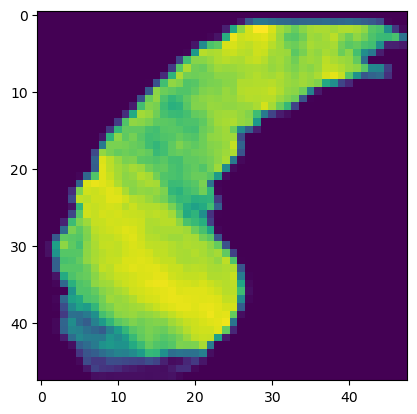

In [31]:
plt.imshow(cnn_train_x[0][0])

## Metrics

In [32]:
METRICS = [
      #tf.keras.metrics.CategoricalCrossentropy(name='categorical cross entropy'),  # same as model's loss
      #tf.keras.metrics.MeanSquaredError(name='Brier score'),
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalseNegatives(name='fn'), 
      #tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      #tf.keras.metrics.AUC(name='auc'),
      #tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

2024-04-23 21:22:45.351777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11437 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:03:00.0, compute capability: 6.0


# CNN Modelling

## Reshaping, test,train,val splitting

In [33]:
cnn_train_x.shape,cnn_train_y.shape

((535, 24, 48, 48), (535, 1, 3))

In [34]:
# Reshape cnn_train_x to add 5th dimension (num_samples, timesteps, height, width,channel)
cnn_train_x_reshaped = cnn_train_x.reshape((-1, 24, 48, 48, 1))
cnn_train_x_reshaped.shape

(535, 24, 48, 48, 1)

In [35]:
# Assuming cnn_train_x and cnn_train_y are your full datasets
num_samples = cnn_train_x_reshaped.shape[0]
train_size = int(num_samples * 0.8)  # 80% for training, adjust as needed

# Splitting data to maintain chronological order
train_x = cnn_train_x_reshaped[:train_size]
train_y = cnn_train_y[:train_size]
test_x = cnn_train_x_reshaped[train_size:]
test_y = cnn_train_y[train_size:]
train_x.shape,train_y.shape,test_x.shape,test_y.shape

((428, 24, 48, 48, 1), (428, 1, 3), (107, 24, 48, 48, 1), (107, 1, 3))

In [36]:
# # Assuming cnn_train_x and cnn_train_y are your full datasets
# num_samples = train_x.shape[0]
# val_size = int(num_samples * 0.85)  # 85% for training, 15% for validation adjust as needed

# # Splitting data to maintain chronological order
# train_x = train_x[:val_size]
# train_y = cnn_train_y[:val_size]
# val_x = cnn_train_x[val_size:]
# val_y = cnn_train_y[val_size:]
# train_x.shape,train_y.shape,val_x.shape,val_y.shape

## Early Stopping, Checkpoints and Metrics Plot

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import datetime

# Setup EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity.
)

### CK 1 
Checkpoint to save the best model at the end of training and in multiples of 5

### CK 2

In [39]:
from tensorflow.keras.callbacks import Callback
import datetime

class DynamicCheckpoint(Callback):
    def __init__(self, base_path, batch_size=32, save_freq=5):
        super(DynamicCheckpoint, self).__init__()
        self.base_path = base_path
        self.batch_size = batch_size
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        # Check if the current epoch meets the saving criteria (every 5 epochs)
        if (epoch + 1) % self.save_freq == 0 or (epoch + 1) == self.params['epochs']:
            self.save_model(epoch)

    def on_train_end(self, logs=None):
        # Check if the last epoch was saved, if not save the model
        if (self.params['epochs']) % self.save_freq != 0:
            self.save_model(self.params['epochs'] - 1)

    def save_model(self, epoch):
        # Format the filename with current date, epoch number, and batch size
        filename = f"{self.base_path}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}_epoch{epoch + 1}_batchsize{self.batch_size}.keras"
        # Save the model
        self.model.save(filename)
        print(f"\nSaving model to {filename}")

# Usage of DynamicCheckpoint
batch_size=16
dynamic_checkpoint = DynamicCheckpoint('./cnn_checkpoints/check_point', batch_size=batch_size, save_freq=5)

### Plot Metrics

In [40]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    plt.figure(figsize=(14, 10))
    metrics = ['precision', 'recall','loss']
    for n, metric in enumerate(metrics):
        name = metric.replace(" ", "_")  # replace spaces with underscores if needed
        plt.subplot(2, 2, n+1)
        plt.plot(history.history[metric], label='Train')
        val_metric = f'val_{metric}'
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.title(f'Training and Validation {metric}')
        plt.legend()
    plt.tight_layout()
    plt.show()


## CNN Model 1

In [92]:
# Build the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten,
    LSTM, Dense,Lambda
)

# def create_cnn_model(input_timesteps, n_features, n_classes, metrics):
#     model = Sequential()
#     # Input shape: (batch_size, timesteps, height, width, channels) #
#     # Since your images are grayscale, channels = 1
#     model.add(TimeDistributed(BatchNormalization(), input_shape=(input_timesteps, n_features, n_features, 1)))
    
#     # First set of Conv + BatchNorm + Conv + BatchNorm + MaxPooling + Dropout
#     model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
#     model.add(TimeDistributed(BatchNormalization()))
#     model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
#     model.add(TimeDistributed(BatchNormalization()))
#     model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#     model.add(TimeDistributed(Dropout(0.4)))
    
#     # Second set
#     model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
#     model.add(TimeDistributed(BatchNormalization()))
#     model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
#     model.add(TimeDistributed(BatchNormalization()))
#     model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#     model.add(TimeDistributed(Dropout(0.4)))
    
#     # Flatten the data for the LSTM layers
#     model.add(TimeDistributed(Flatten()))

#     # LSTM layers
#     model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
#     model.add(LSTM(256, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))  # return_sequences=True to keep time dimension

#     # Since the LSTM layers now output (None, timesteps, features), we directly connect to Dense without reshaping
#     model.add(Dense(n_classes, activation='softmax'))  # Apply Dense layer to each time step
#     # Adding a Reshape layer to adjust the output shape to include the time dimension
#     model.add(Reshape((1, n_classes)))  # Reshaping the output to (None, 1, 3)
    
#     # Compile the model
#     model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=metrics)
#     return model

def create_cnn_model(input_timesteps, n_features, n_classes, metrics):
    model = Sequential()
    # Input shape: (batch_size, timesteps, height, width, channels) #
    # Since your images are grayscale, channels = 1
    model.add(TimeDistributed(BatchNormalization(), input_shape=(input_timesteps, n_features, n_features, 1)))
    
    # First set of Conv + BatchNorm + Conv + BatchNorm + MaxPooling + Dropout
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.4)))
    
    # Second set
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.4)))
    
    # Flatten the data for the LSTM layers
    model.add(TimeDistributed(Flatten()))

    # LSTM layers
    model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
    model.add(LSTM(256, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))

    # Output layer
    model.add(Dense(n_classes, activation='softmax'))
    model.add(Reshape((1, n_classes)))  # Reshaping the output to (None, 1, 3)
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=metrics)
    return model

# CNN Working

In [92]:
# Build the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten,
    LSTM, Dense,Lambda
)

def create_cnn_model(input_timesteps, n_features, n_classes, metrics):
    cnn_input = Input(shape=(24, 48, 48, 1))
    
    cnn = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(cnn_input)
    cnn = BatchNormalization()(cnn)
    cnn = MaxPooling3D(pool_size=(2, 2, 2))(cnn)
    
    # cnn = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same')(cnn)
    # cnn = BatchNormalization()(cnn)
    # cnn = MaxPooling3D(pool_size=(2, 2, 2))(cnn)
    
    # cnn = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(cnn)
    # cnn = BatchNormalization()(cnn)
    # cnn = MaxPooling3D(pool_size=(2, 2, 2))(cnn)
    
    cnn = Flatten()(cnn)
    cnn1 = Dense(32, activation='relu')(cnn)
    cnn_output = Dense(3, activation='relu')(cnn1)

    
    model = Sequential()
    # Input shape: (batch_size, timesteps, height, width, channels) #
    # Since your images are grayscale, channels = 1
    model.add(TimeDistributed(BatchNormalization(), input_shape=(input_timesteps, n_features, n_features, 1)))
    
    # First set of Conv + BatchNorm + Conv + BatchNorm + MaxPooling + Dropout
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.4)))
    
    # Second set
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.4)))
    
    # Flatten the data for the LSTM layers
    model.add(TimeDistributed(Flatten()))

    # LSTM layers
    model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
    model.add(LSTM(256, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))

    # Output layer
    model.add(Dense(n_classes, activation='softmax'))
    model.add(Reshape((1, n_classes)))  # Reshaping the output to (None, 1, 3)
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=metrics)
    return model

In [93]:
class_weights

{0: 1.447089947089947, 1: 1.4356955380577427, 2: 0.6201814058956916}

In [94]:
cnn_train_x_reshaped.shape,cnn_train_y.shape

((535, 24, 48, 48, 1), (535, 1, 3))

In [95]:
# Shape details
batch_size=16
input_timesteps = cnn_train_x_reshaped.shape[1]  # Timesteps per sequence 24
n_features = 48       # Image dimensions (48x48)
n_classes = cnn_train_y.shape[2]         # Number of classes (high, medium, low) 3
cnn_model = create_cnn_model(input_timesteps, n_features, n_classes,metrics=METRICS)

# Display model architecture
cnn_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_172 (Time  (None, 24, 48, 48, 1)     4         
 Distributed)                                                    
                                                                 
 time_distributed_173 (Time  (None, 24, 46, 46, 32)    320       
 Distributed)                                                    
                                                                 
 time_distributed_174 (Time  (None, 24, 46, 46, 32)    128       
 Distributed)                                                    
                                                                 
 time_distributed_175 (Time  (None, 24, 44, 44, 32)    9248      
 Distributed)                                                    
                                                                 
 time_distributed_176 (Time  (None, 24, 44, 44, 32)  

In [96]:
train_y.shape,test_y.shape

((428, 1, 3), (107, 1, 3))

In [97]:
test_y.shape

(107, 1, 3)

In [98]:
%%time
history = cnn_model.fit(
    train_x,
    train_y,
    epochs=100,                    # Number of epochs to train for
    batch_size=batch_size,         # Number of samples per gradient update
    validation_data=(test_x, test_y),  # Use explicit validation data
    callbacks=[ early_stopping,dynamic_checkpoint],  # Early stopping and checkpointing
    verbose=1,
    class_weight=class_weights
)

Epoch 1/100
27/27 [==============================] - 19s 277ms/step - loss: 1.1754 - precision: 0.2993 - recall: 0.0822 - val_loss: 1.1268 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 7s 249ms/step - loss: 1.1124 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1337 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 7s 250ms/step - loss: 1.1106 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1864 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
27/27 [==============================] - 7s 247ms/step - loss: 1.0966 - precision: 0.4000 - recall: 0.0047 - val_loss: 1.1574 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
27/27 [==============================] - ETA: 0s - loss: 1.0818 - precision: 0.2692 - recall: 0.0164
Saving model to ./cnn_checkpoints/check_point_20240423-220453_epoch5_batchsize16.keras
27/27 [============

In [100]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import numpy as np

# Load the model
#model = load_model('path_to_your_saved_model.h5')

# Make predictions
predictions = cnn_model.predict(test_x)

# Convert predictions from one-hot encoded to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Assuming test_y is also one-hot encoded, convert it back to class labels
actual_classes = np.argmax(test_y, axis=1)

# Generate classification report
report = classification_report(actual_classes, predicted_classes, target_names=['High', 'Medium', 'No Rain'])

# Print the classification report
print(report)

4/4 [==============================] - 1s 38ms/step
              precision    recall  f1-score   support

        High       0.00      0.00      0.00         0
      Medium       0.00      0.00      0.00         0
     No Rain       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         0
   macro avg       0.00      0.00      0.00         0
weighted avg       0.00      0.00      0.00         0
 samples avg       0.00      0.00      0.00         0



/home/dasari.uda/.conda/envs/deeplearning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dasari.uda/.conda/envs/deeplearning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dasari.uda/.conda/envs/deeplearning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

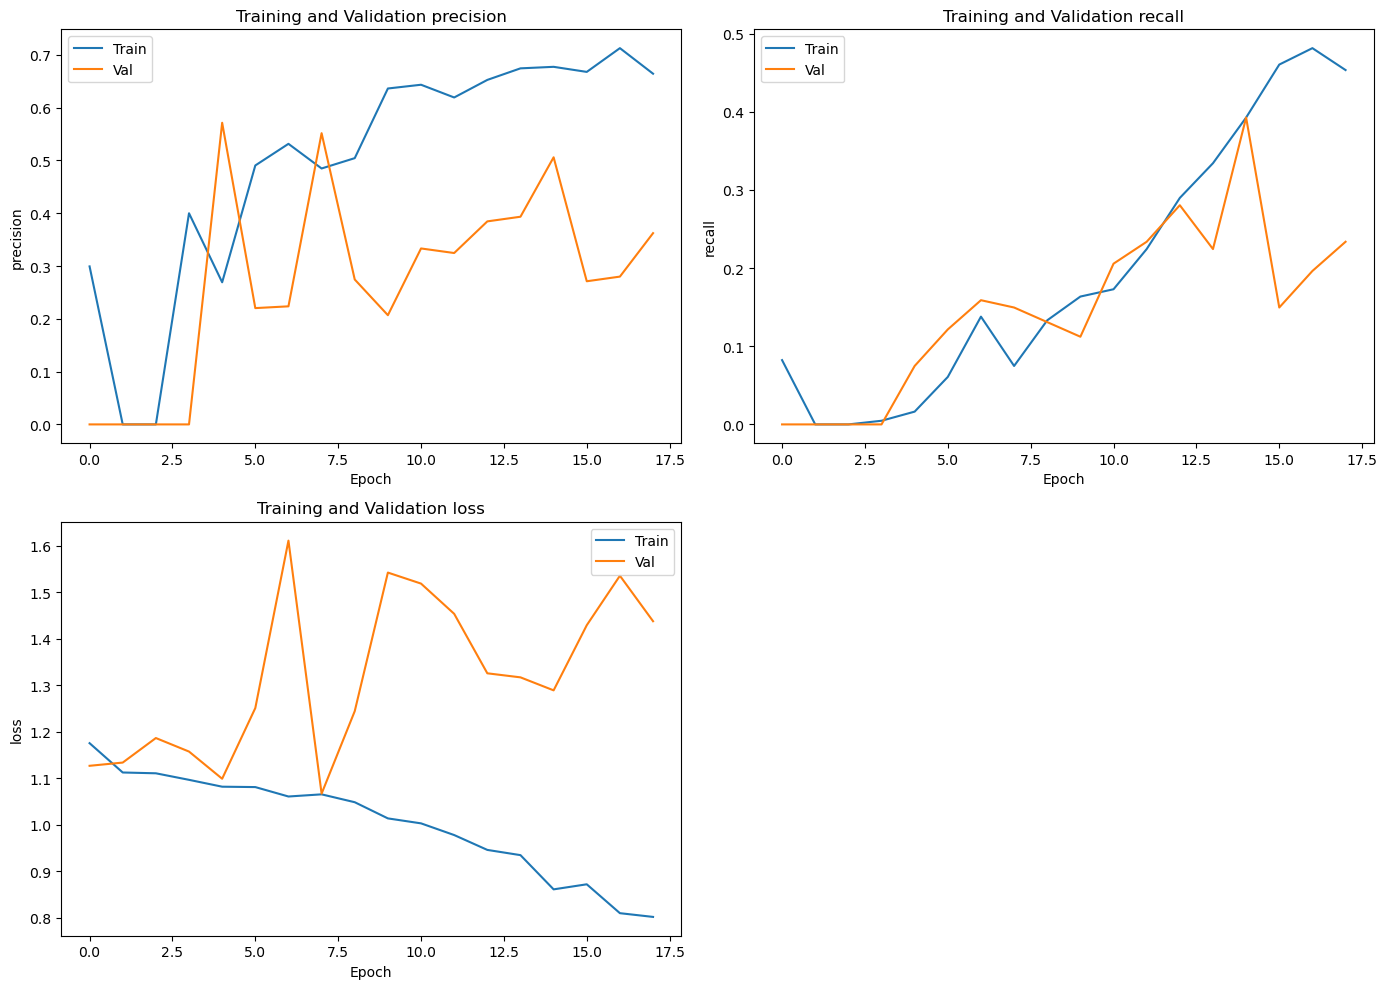

In [99]:
# Call the function with the history from your training
plot_metrics(history)

## CNN Model 2

In [195]:
# Build the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten,
    LSTM, Dense
)

def cnn_model1(train_x,input_timesteps, output_timesteps, n_features,n_classes):
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, *train_x.shape[2:])))#num of records,72,12,1,1
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.20, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, 48, 48, 64)))    
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.20, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    #model.add(TimeDistributed(Dense(units=64, name = 'dense_1', activation = 'relu')))
    model.add(TimeDistributed(Flatten()))
    model.add(TimeDistributed(Dense(units=n_classes, name = 'output_layer', activation = 'softmax')))

    optimizer = tf.keras.optimizers.RMSprop(lr=0.004, clipvalue=1.0)
#   model.compile(loss = tf.keras.losses.CategoricalCrossentropy() , optimizer = optimizer, metrics = ['accuracy'])
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=METRICS)
    return model

In [196]:
# Shape details
batch_size=16
input_timesteps = cnn_train_x_reshaped.shape[1]  # Timesteps per sequence 24
output_timesteps=1
n_features = cnn_train_x_reshaped[2:]      # Image dimensions (48x48)
n_classes = cnn_train_y.shape[2]         # Number of classes (high, medium, low) 3
cnn_model1 = cnn_model1(cnn_train_x_reshaped,input_timesteps, output_timesteps,n_features, n_classes)

# Display model architecture
cnn_model1.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_norm_0 (BatchNormali  (None, 24, 48, 48, 1)     4         
 zation)                                                         
                                                                 
 conv_lstm_1 (ConvLSTM2D)    (None, 24, 48, 48, 64)    166656    
                                                                 
 dropout_1 (Dropout)         (None, 24, 48, 48, 64)    0         
                                                                 
 batch_norm_1 (BatchNormali  (None, 24, 48, 48, 64)    256       
 zation)                                                         
                                                                 
 conv_lstm_2 (ConvLSTM2D)    (None, 48, 48, 64)        164096    
                                                                 
 dropout_2 (Dropout)         (None, 48, 48, 64)      

In [197]:
train_y.shape,test_y.shape

((428, 1, 3), (107, 1, 3))

In [198]:
%%time
history1 = cnn_model1.fit(
    train_x,
    train_y,
    epochs=100,                    # Number of epochs to train for
    batch_size=batch_size,         # Number of samples per gradient update
    validation_data=(test_x, test_y),  # Use explicit validation data
    callbacks=[ early_stopping,dynamic_checkpoint],  # Early stopping and checkpointing
    verbose=1
)

Epoch 1/100


2024-04-23 21:07:30.314566: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/sequential_13/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


27/27 [==============================] - 35s 926ms/step - loss: 10.8154 - precision: 0.3774 - recall: 0.3693 - val_loss: 11.6905 - val_precision: 0.2430 - val_recall: 0.2430
Epoch 2/100
27/27 [==============================] - 24s 887ms/step - loss: 12.6535 - precision: 0.2150 - recall: 0.2150 - val_loss: 12.2015 - val_precision: 0.2430 - val_recall: 0.2430
Epoch 3/100
27/27 [==============================] - 24s 887ms/step - loss: 12.6535 - precision: 0.2150 - recall: 0.2150 - val_loss: 12.2015 - val_precision: 0.2430 - val_recall: 0.2430
Epoch 4/100
27/27 [==============================] - 24s 887ms/step - loss: 12.6535 - precision: 0.2150 - recall: 0.2150 - val_loss: 12.2015 - val_precision: 0.2430 - val_recall: 0.2430
Epoch 5/100
27/27 [==============================] - ETA: 0s - loss: 12.6535 - precision: 0.2150 - recall: 0.2150
Saving model to ./cnn_checkpoints/check_point_20240423-210933_epoch5_batchsize16.keras
27/27 [==============================] - 24s 893ms/step - loss: 12.

--------------------------------------------
# RNN

## RNN Sequence Creation

In [122]:
def create_sequences_rnn(data,  feature_columns, label_columns, stride, past_time_steps=3, future_time_steps=1):
    X, y = [], []
    
    for i in range(0, len(data) - past_time_steps - stride - future_time_steps + 1, stride):
        X.append(data.iloc[i : (i + past_time_steps)][feature_columns].values.tolist())
        y.append(data.iloc[i + stride + past_time_steps : i + stride + past_time_steps + future_time_steps][label_columns].values)
    
    return np.array(X), np.array(y)

In [123]:
day_level_data_with_one_hot.head()

,date,year_month,day_sin,day_cos,year_sin,year_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Atm_Press_hPa,Wind_x,Wind_y,Visibility_mi,sum_precip_in,rain_class,High_Rain,Medium_Rain,No_Rain
0,2014-10-01,2014-10,6.738822e-14,9.456325e-14,-0.999985,-0.002111,55.666667,79.375000,5183.333333,993.000000,0.423936,1.821162,9.250000,0.15,High_Rain,1,0,0
1,2014-10-02,2014-10,3.391708e-13,-3.548550e-13,-0.999874,0.015091,58.708333,85.583333,3075.000000,988.687500,-1.583594,2.211282,6.250000,0.94,High_Rain,1,0,0
2,2014-10-03,2014-10,-3.720542e-13,-1.794861e-15,-0.999466,0.032289,56.000000,79.041667,3195.833333,978.737500,-0.675702,-6.158806,8.416667,0.81,High_Rain,1,0,0
3,2014-10-04,2014-10,6.795490e-15,-5.167626e-14,-0.998763,0.049477,49.166667,81.666667,2795.833333,977.262500,-2.718467,-3.856504,8.875000,0.49,High_Rain,1,0,0
4,2014-10-05,2014-10,3.598510e-13,9.454012e-14,-0.997764,0.066650,45.000000,68.791667,4120.833333,978.191667,-3.623998,-4.426348,9.916667,0.01,Medium_Rain,0,1,0


In [124]:
# Training data - creating Parameters
stride = 1 # so skipping next day (1- records per day)
past_time_steps = 3 * 1 # 3-days past
future_time_steps = 1 * 1 # 1-day in future (which is next to next date)

######################################################### 1

# 1. Creating the window of sequential data year-months
rnn_mnts= day_level_data_with_one_hot.year_month.unique().tolist()
rnn_yr_mnt_lst = []
for i in range(0, len(rnn_mnts), 6):
    # print(mnts[i: i+6])
    rnn_yr_mnt_lst.append(rnn_mnts[i: i+6])

######################################################### 2
### Sequence Training Data - Creating
data_x, data_y = [], []

feature_cols = ['day_sin','day_cos','year_sin','year_cos','Temp_F','RH_pct','Low_Cloud_Ht_ft','Atm_Press_hPa','Wind_x','Wind_y','Visibility_mi']
labels_cols = ['High_Rain', 'Medium_Rain', 'No_Rain']
# Creating the Sequence data for each window separately and then appending
for i in rnn_yr_mnt_lst:
    # x, y = prepare_data(train_df_scaled, i, cols_to_use, n_time_steps, future_steps)
    x, y = create_sequences_rnn(day_level_data_with_one_hot[day_level_data_with_one_hot.year_month.isin(i)], feature_cols, labels_cols, stride, past_time_steps, future_time_steps)
    # print(x.shape, y.shape)
    data_x.append(x)
    data_y.append(y)

######################################################### 3
# Concatenate the arrays along the first axis after the loop
rnn_train_x = np.concatenate(data_x, axis=0)
rnn_train_y = np.concatenate(data_y, axis=0)
rnn_train_x.shape, rnn_train_y.shape

((535, 3, 11), (535, 1, 3))

##### The output is of shape: (No_of_batches, No_of_timesteps, num_features)
* 3 - Past 3 days
* 11 - Number of Features

# RNN Modelling

In [ ]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, BatchNormalization, Dropout, Flatten, Dense, Reshape, RepeatVector, TimeDistributed
from keras.optimizers import RMSprop

def build_model(input_timesteps, output_timesteps, n_features):
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, n_features,1,1)))#num of records,72,12,1,1
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.20, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, n_features,1,64)))#(None, 24, 12, 64)
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.20, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    #model.add(TimeDistributed(Dense(units=64, name = 'dense_1', activation = 'relu')))
    model.add(TimeDistributed(Flatten()))
    model.add(TimeDistributed(Dense(units=3, name = 'output_layer', activation = 'softmax')))

#     optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#     optimizer = tf.keras.optimizers.Adam(0.1)
    # model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])

    optimizer = tf.keras.optimizers.RMSprop(lr=0.004, clipvalue=1.0)
#    model.compile(loss = tf.keras.losses.CategoricalCrossentropy() , optimizer = optimizer, metrics = ['accuracy'])
    model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    optimizer=optimizer, 
    metrics=['accuracy', Precision(), Recall(), F1Score()]
)
    return model

In [116]:
rnn_train_x.shape,rnn_train_y.shape

((535, 3, 11), (535, 1, 3))

In [117]:
# Reshape Rnn_train_x to add 4th,5th dimensions
# Assuming rnn_train_x.shape gives (num_samples, timesteps, features)
num_samples, timesteps, features = rnn_train_x.shape
# Reshape rnn_train_x to include height, width, and channel dimensions
rnn_train_x_reshaped = rnn_train_x.reshape((num_samples, timesteps, 1, 1, features))
# Output the new shape
print(rnn_train_x_reshaped.shape)

SyntaxError: invalid syntax (4239654977.py, line 2)

In [54]:
# Assuming cnn_train_x and cnn_train_y are your full datasets
num_samples = cnn_train_x_reshaped.shape[0]
train_size = int(num_samples * 0.8)  # 80% for training, adjust as needed

# Splitting data to maintain chronological order
train_x = cnn_train_x_reshaped[:train_size]
train_y = cnn_train_y[:train_size]
test_x = cnn_train_x_reshaped[train_size:]
test_y = cnn_train_y[train_size:]
train_x.shape,train_y.shape,test_x.shape,test_y.shape

((428, 24, 48, 48, 1), (428, 3), (107, 24, 48, 48, 1), (107, 3))

In [55]:
# Assuming cnn_train_x and cnn_train_y are your full datasets
num_samples = train_x.shape[0]
val_size = int(num_samples * 0.85)  # 85% for training, 15% for validation adjust as needed

# Splitting data to maintain chronological order
train_x = train_x[:val_size]
train_y = cnn_train_y[:val_size]
val_x = cnn_train_x[val_size:]
val_y = cnn_train_y[val_size:]
train_x.shape,train_y.shape,val_x.shape,val_y.shape

((363, 24, 48, 48, 1), (363, 3), (172, 24, 48, 48), (172, 3))

In [53]:
# Shape details
batch_size=16
input_timesteps = cnn_train_x_reshaped.shape[1]  # Timesteps per sequence 24
n_features = 48       # Image dimensions (48x48)
n_classes = cnn_train_y.shape[1]         # Number of classes (high, medium, low) 3
cnn_model = create_cnn_model(input_timesteps, n_features, n_classes,metrics=METRICS)


# Display model architecture
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeD  (None, 24, 48, 48, 1)     4         
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, 24, 46, 46, 32)    320       
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, 24, 46, 46, 32)    128       
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, 24, 44, 44, 32)    9248      
 istributed)                                                     
                                                                 
 time_distributed_18 (TimeD  (None, 24, 44, 44, 32)   

In [56]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import datetime

# Setup EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity.
)

-------------------------------------
# Hybrid Model